In [58]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

In [59]:
df = pd.read_csv("UCI_Credit_Card.csv")

# Clean column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

df.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [60]:
target = [c for c in df.columns if "default" in c.lower()][0]
target

'default.payment.next.month'

In [61]:
X = df.drop(columns=[target])
y = df[target]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [63]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, probs)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7160129700502025

In [64]:
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

calibration_gap = np.abs(prob_pred - prob_true)
calibration_gap_mean = calibration_gap.mean()

calibration_gap_mean

np.float64(0.09098145966246154)

In [65]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(X_train)

distances, _ = nn.kneighbors(X_test)
ood_score = distances.mean(axis=1)

In [66]:
neighbor_idx = nn.kneighbors(X_test, return_distance=False)

fail_rate_similar = []
for idx_list in neighbor_idx:
    fail_rate_similar.append(y_train.iloc[idx_list].mean())

fail_rate_similar = np.array(fail_rate_similar)

In [67]:
#CREDIT LIMIT column
exposure = X_test["limit_bal"]
exposure = exposure / exposure.max()

In [68]:
# Row-wise calibration error (proxy)
calib_error = np.abs(probs - y_test.values)

mistrust_score = (
    0.3 * calib_error +
    0.3 * (ood_score / ood_score.max()) +
    0.2 * fail_rate_similar +
    0.2 * exposure.values
)

# Normalize 0–1
mistrust_score = (mistrust_score - mistrust_score.min()) / (
    mistrust_score.max() - mistrust_score.min()
)

In [83]:
def tag(score):
    if score < 0.45:
        return "SAFE"
    elif score < 0.55:
        return "CAUTION"
    else:
        return "REVIEW"

In [70]:
results = X_test.copy()

results["model_probability"] = probs
results["mistrust_score"] = mistrust_score
results["decision_tag"] = tags
results["actual_default"] = y_test.values

results.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,model_probability,mistrust_score,decision_tag,actual_default
8941,8942,230000.0,1,2,2,30,0,0,0,0,...,5000.0,4000.0,2029.0,2000.0,2500.0,1300.0,0.166076,0.177407,SAFE,0
17618,17619,80000.0,2,1,1,32,-1,3,2,-1,...,0.0,0.0,4844.0,0.0,0.0,0.0,0.310568,0.437335,SAFE,1
27895,27896,100000.0,2,1,2,29,0,0,0,0,...,70001.0,3769.0,2008.0,1950.0,2001.0,18000.0,0.080079,0.121370,SAFE,0
16103,16104,10000.0,2,2,1,37,-1,4,3,2,...,0.0,0.0,500.0,400.0,0.0,36.0,0.359188,0.519565,SAFE,0
4422,4423,110000.0,2,2,1,34,0,0,0,0,...,2000.0,2000.0,1500.0,5000.0,6400.0,0.0,0.243785,0.312942,SAFE,0


In [84]:
results[
    (results["model_probability"] < 0.4) &
    (results["actual_default"] == 1)
][["model_probability", "mistrust_score", "decision_tag", "actual_default"]].head()

,model_probability,mistrust_score,decision_tag,actual_default
17618,0.310568,0.437335,SAFE,1
25054,0.251583,0.634736,SAFE,1
29234,0.270443,0.503954,SAFE,1
29540,0.250446,0.590489,SAFE,1
19453,0.280024,0.606949,SAFE,1


In [85]:
results.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'model_probability', 'mistrust_score', 'decision_tag',
       'actual_default'],
      dtype='object')

In [86]:
results[
    (results["model_probability"] < 0.4) &
    (results["mistrust_score"] > 0.45)
].head(50)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,model_probability,mistrust_score,decision_tag,actual_default
16103,16104,10000.0,2,2,1,37,-1,4,3,2,...,0.0,0.0,500.0,400.0,0.0,36.0,0.359188,0.519565,SAFE,0
25054,25055,20000.0,1,2,2,49,0,0,0,0,...,1621.0,1292.0,1166.0,390.0,1320.0,0.0,0.251583,0.634736,SAFE,1
29234,29235,10000.0,1,2,2,23,0,0,2,0,...,3775.0,0.0,1000.0,75.0,994.0,0.0,0.270443,0.503954,SAFE,1
29540,29541,10000.0,1,2,2,40,0,0,0,0,...,1500.0,1200.0,1137.0,329.0,500.0,251.0,0.250446,0.590489,SAFE,1
19453,19454,160000.0,2,1,1,35,1,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,1404.0,0.280024,0.606949,SAFE,1
17519,17520,20000.0,2,1,2,33,0,0,3,3,...,5000.0,1000.0,0.0,0.0,1400.0,0.0,0.298213,0.451492,SAFE,0
435,436,270000.0,2,2,1,32,1,2,2,2,...,10000.0,8000.0,0.0,16000.0,8000.0,0.0,0.327316,0.605711,SAFE,1
18188,18189,50000.0,1,2,2,48,0,0,0,0,...,2000.0,1500.0,2000.0,0.0,2000.0,1000.0,0.249730,0.534411,SAFE,1
13082,13083,210000.0,2,2,1,46,-1,-1,-1,0,...,2768.0,5536.0,0.0,1075.0,2006.0,1344.0,0.117403,0.649214,SAFE,1
17142,17143,80000.0,2,2,1,26,0,0,2,4,...,2820.0,6000.0,0.0,0.0,3000.0,0.0,0.272302,0.498645,SAFE,1


In [87]:
results[
    (results["model_probability"] < 0.3) &
    (results["decision_tag"] == "REVIEW")
].head(10)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,model_probability,mistrust_score,decision_tag,actual_default


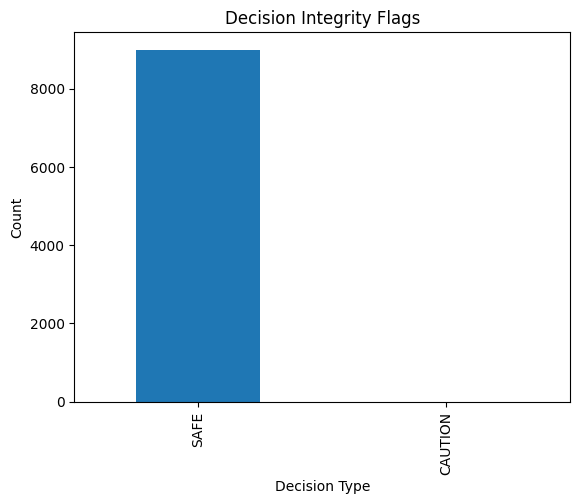

In [82]:
results["decision_tag"].value_counts().plot(kind="bar")
plt.title("Decision Integrity Flags")
plt.xlabel("Decision Type")
plt.ylabel("Count")
plt.show()

In [88]:
results.to_csv("results.csv", index=False)